In [779]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from abc import ABC, abstractclassmethod
from EOF import EOF
from scipy.fftpack import fft,ifft,fftfreq
import datetime 

In [780]:
file  = "HSt42_10/RH80_PR10_1000day_startfrom_0day_final.dat"
ds = h5py.File(file, "r")
print(ds.keys())
# dycore = Dycore(file)
# u = dycore.getVar("grid_u_c_xyzt")
# # print(u.shape)

<KeysViewHDF5 ['_types', 'convection_xyzt', 'factor1_xyzt', 'factor2_xyzt', 'factor3_xyzt', 'factor4_xyzt', 'grid_div_xyzt', 'grid_geopots_xyzt', 'grid_p_full_xyzt', 'grid_p_half_xyzt', 'grid_ps_c_xyzt', 'grid_ps_p_xyzt', 'grid_t_c_xyzt', 'grid_t_n_xyzt', 'grid_t_p_xyzt', 'grid_tracers_c_xyzt', 'grid_tracers_diff_xyzt', 'grid_tracers_n_xyzt', 'grid_tracers_p_xyzt', 'grid_u_c_xyzt', 'grid_u_n_xyzt', 'grid_u_p_xyzt', 'grid_v_c_xyzt', 'grid_v_n_xyzt', 'grid_v_p_xyzt', 'grid_vor_xyzt', 'grid_z_full_xyzt', 'grid_δtracers_xyzt', 'grid_δu_xyzt', 'grid_δv_xyzt', 'spe_div_c_xyzt', 'spe_div_p_xyzt', 'spe_lnps_c_xyzt', 'spe_lnps_p_xyzt', 'spe_t_c_xyzt', 'spe_t_p_xyzt', 'spe_tracers_c_xyzt', 'spe_tracers_p_xyzt', 'spe_vor_c_xyzt', 'spe_vor_p_xyzt']>


In [781]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        self.Rd = 287
        self.cp = 1004
        self.g  = 9.81
        self.H  = 6800
        self.a  = 6.37122e6
        self.u  = self.getVar("grid_u_c_xyzt")
        self.u_p  = self.getVar("grid_u_p_xyzt")
        self.u_n  = self.getVar("grid_u_n_xyzt")
        
        
        self.v  = self.getVar("grid_v_c_xyzt")
        self.t  = self.getVar("grid_t_c_xyzt")
        self.ps = self.getVar("grid_ps_c_xyzt")
        self.p  = self.getVar("grid_p_full_xyzt")
        self.p_half  = self.getVar("grid_p_half_xyzt")

        self.qv   = self.getVar("grid_tracers_c_xyzt")
        self.qv_p = self.getVar("grid_tracers_p_xyzt")
        self.qv_n = self.getVar("grid_tracers_n_xyzt")
        
        
        self.qv_diff = self.getVar("grid_tracers_diff_xyzt")
        self.factor1 = self.getVar("factor1_xyzt")
        self.factor2 = self.getVar("factor2_xyzt")
        self.factor3 = self.getVar("factor3_xyzt")
        # self.factor4 = self.getVar("factor4_xyzt")


        self.convection = self.getVar("convection_xyzt")
        
        # self.theta = self.t * (self.ps / self.p)**(self.Rd/self.cp)
        
        # self.Uzm   = np.nanmean(self.u, axis=3)
        # self.Vzm   = np.nanmean(self.v, axis=3)
        # self.THzm  = np.nanmean(self.theta, axis=3)
        # self.Pzm   = np.nanmean(self.p, axis=3)
        # self.Tzm   = np.nanmean(self.t, axis=3)
        
        # ### anamoly
        # self.Vzmtm  = np.nanmean(self.Vzm, axis=0)
        # self.Uzmtm  = np.nanmean(self.Uzm, axis=0)
        # self.THzmtm = np.nanmean(self.THzm, axis=0)
        # self.Pzmtm  = np.nanmean(self.Pzm, axis=0)
        # self.Tzmtm  = np.nanmean(self.Tzm, axis=0)

        # self.Vza     = np.zeros(self.u.shape)
        # self.Uza     = np.zeros(self.u.shape)
        # self.THETAza = np.zeros(self.u.shape)
        # self.Pza     = np.zeros(self.u.shape)
        # self.Tza     = np.zeros(self.t.shape)

        # for i in range(0,128):
        #     self.Vza[:,:,:,i]     = self.v[:,:,:,i] - self.Vzm
        #     self.Uza[:,:,:,i]     = self.u[:,:,:,i] - self.Uzm
        #     self.THETAza[:,:,:,i] = self.theta[:,:,:,i] - self.THzm
        #     self.Pza[:,:,:,i]     = self.p[:,:,:,i] - self.Pzm
        #     self.Tza[:,:,:,i]     = self.t[:,:,:,i] - self.Tzm
        
        ### the variables for plot
        self.sigma_mean           = np.nanmean(self.p/self.ps, axis=(0,3))
        self.sigma_onlyz          = np.nanmean(self.sigma_mean, axis=1)
        self.y                    = np.linspace(-90,90,64)
        self.yy, self.sigma_mean2 = np.meshgrid(self.y,self.sigma_onlyz)
        
        ### cooridate
        self.x  = np.linspace(-180,180,128)
        self.y  = np.linspace(-90,90,64)
        self.xd = np.deg2rad(self.x)
        self.yd = np.deg2rad(self.y)
        # self.xx, self.yy = np.meshgrid(self.x,self.y)
        
        # WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
        self.cy     = np.cos(self.yd)
        self.cy[0]  = np.nan
        self.cy[-1] = np.nan

    def getVar(self, var):
        # self.u  = self.ds["grid_u_c_xyzt"]
        return np.asarray(self.ds[var])
    
    def cal_KE(self):
        self.KE = (self.u**2 + self.v**2)
        self.KE_mean = np.nanmean(self.KE, axis=(1,3))
        return self.KE_mean
    
    def cal_pre(self):
        self.Prec = np.zeros(self.u.shape)
        for i in range(1,20-1):
            self.Prec[:,i,:,:] = 1/self.g * self.qv_diff[:,i,:,:] * (self.p_half[:,i+1,:,:] - self.p_half[:,i,:,:])
        self.Prec[:, 0,:,:] = 1/self.g * self.qv_diff[:, 0,:,:] * (self.p_half[:, 1,:,:] - self.p_half[:, 0,:,:])
        # self.Prec[:,-1,:,:] = 1/self.g * self.qv[:,-1,:,:] * (self.p_half[:,-1,:,:] - self.p_half[:,-2,:,:])
        
        self.Prec_mean = np.nansum(self.Prec, axis=(1))
        self.Prec_mean2 = np.nanmean(self.Prec_mean, axis=(2))
        
        return self.Prec_mean2
    
    def cal_t(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[:,:,:,:], axis=(1,3))
        return self.t_mean
    
    def cal_t_last(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[-100:,:,:,:], axis=(1,3))
        return self.t_mean
    
    def cal_diff(self):
        
        return np.nanmean(self.factor3, axis=(1,3))

In [782]:
def read_all_var(pr, start, end, internal_day, total_file):
    qv_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    qv_diff_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    u_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    v_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    t_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    p_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    ps_all = np.zeros(((total_file, 100, 20 , 64, 128)))
    
    p_half_all = np.zeros(((total_file, 100, 21 , 64, 128)))

    a = 0
    for day in range(start,end+internal_day,internal_day):
        # print(day)
        file  = f"HSt42_{pr}/RH80_PR{pr}_1000day_startfrom_{day}day_final.dat"
        dycore = Dycore(file)
        
     #   Prec[a,:,:]    = dycore.cal_pre()
        
        qv_all[a,:,:,:,:]   = dycore.qv
        qv_diff_all[a,:,:,:,:]   = dycore.qv_diff
        u_all[a,:,:,:,:]    = dycore.u
        v_all[a,:,:,:,:]    = dycore.v
        t_all[a,:,:,:,:]    = dycore.t
        p_all[a,:,:,:,:]    = dycore.p
        ps_all[a,:,:,:,:]    = dycore.ps
        
        p_half_all[a,:,:,:,:]    = dycore.p_half
        
        # print(a)
        a+=1
    # qv_all_new      = np.nanmean(qv_all  , axis=0)
    # qv_diff_new      = np.nanmean(qv_diff_all  , axis=0)
    # u_new      = np.nanmean(u_all  , axis=0)
    # v_new      = np.nanmean(v_all  , axis=0)
    # t_new      = np.nanmean(t_all  , axis=0)
    # p_new      = np.nanmean(p_all  , axis=0)
    # p_half_new      = np.nanmean(p_half_all  , axis=0)
    


    # qv = qv_all
    # qv_diff = qv_diff_new
    # u = u_new
    # v = v_new
    # t = t_new
    # p = p_new
    # p_half = p_half_new
    return qv_all, qv_diff_all, u_all, v_all, t_all, p_all, ps_all, p_half_all

In [783]:
def cal_pre(qv_diff, p_half):
    g = 9.81
    Prec = np.zeros(qv_diff.shape)
    for i in range(1,20-1):
        Prec[:,i,:,:] = 1/g * qv_diff[:,i,:,:] * (p_half[:,i+1,:,:] - p_half[:,i,:,:])
    Prec[:, 0,:,:] = 1/g * qv_diff[:, 0,:,:] * (p_half[:, 1,:,:] - p_half[:, 0,:,:])
    # self.Prec[:,-1,:,:] = 1/self.g * self.qv[:,-1,:,:] * (self.p_half[:,-1,:,:] - self.p_half[:,-2,:,:])
    
    Prec_mean = np.nansum(Prec, axis=(1))
    Prec_mean2 = np.nanmean(Prec_mean, axis=(2))
    
    return Prec_mean2

In [784]:
def cal_KE(u, v):
    KE = (u**2 + v**2)
    KE_mean = np.nanmean(KE, axis=(1,3))
    return KE_mean

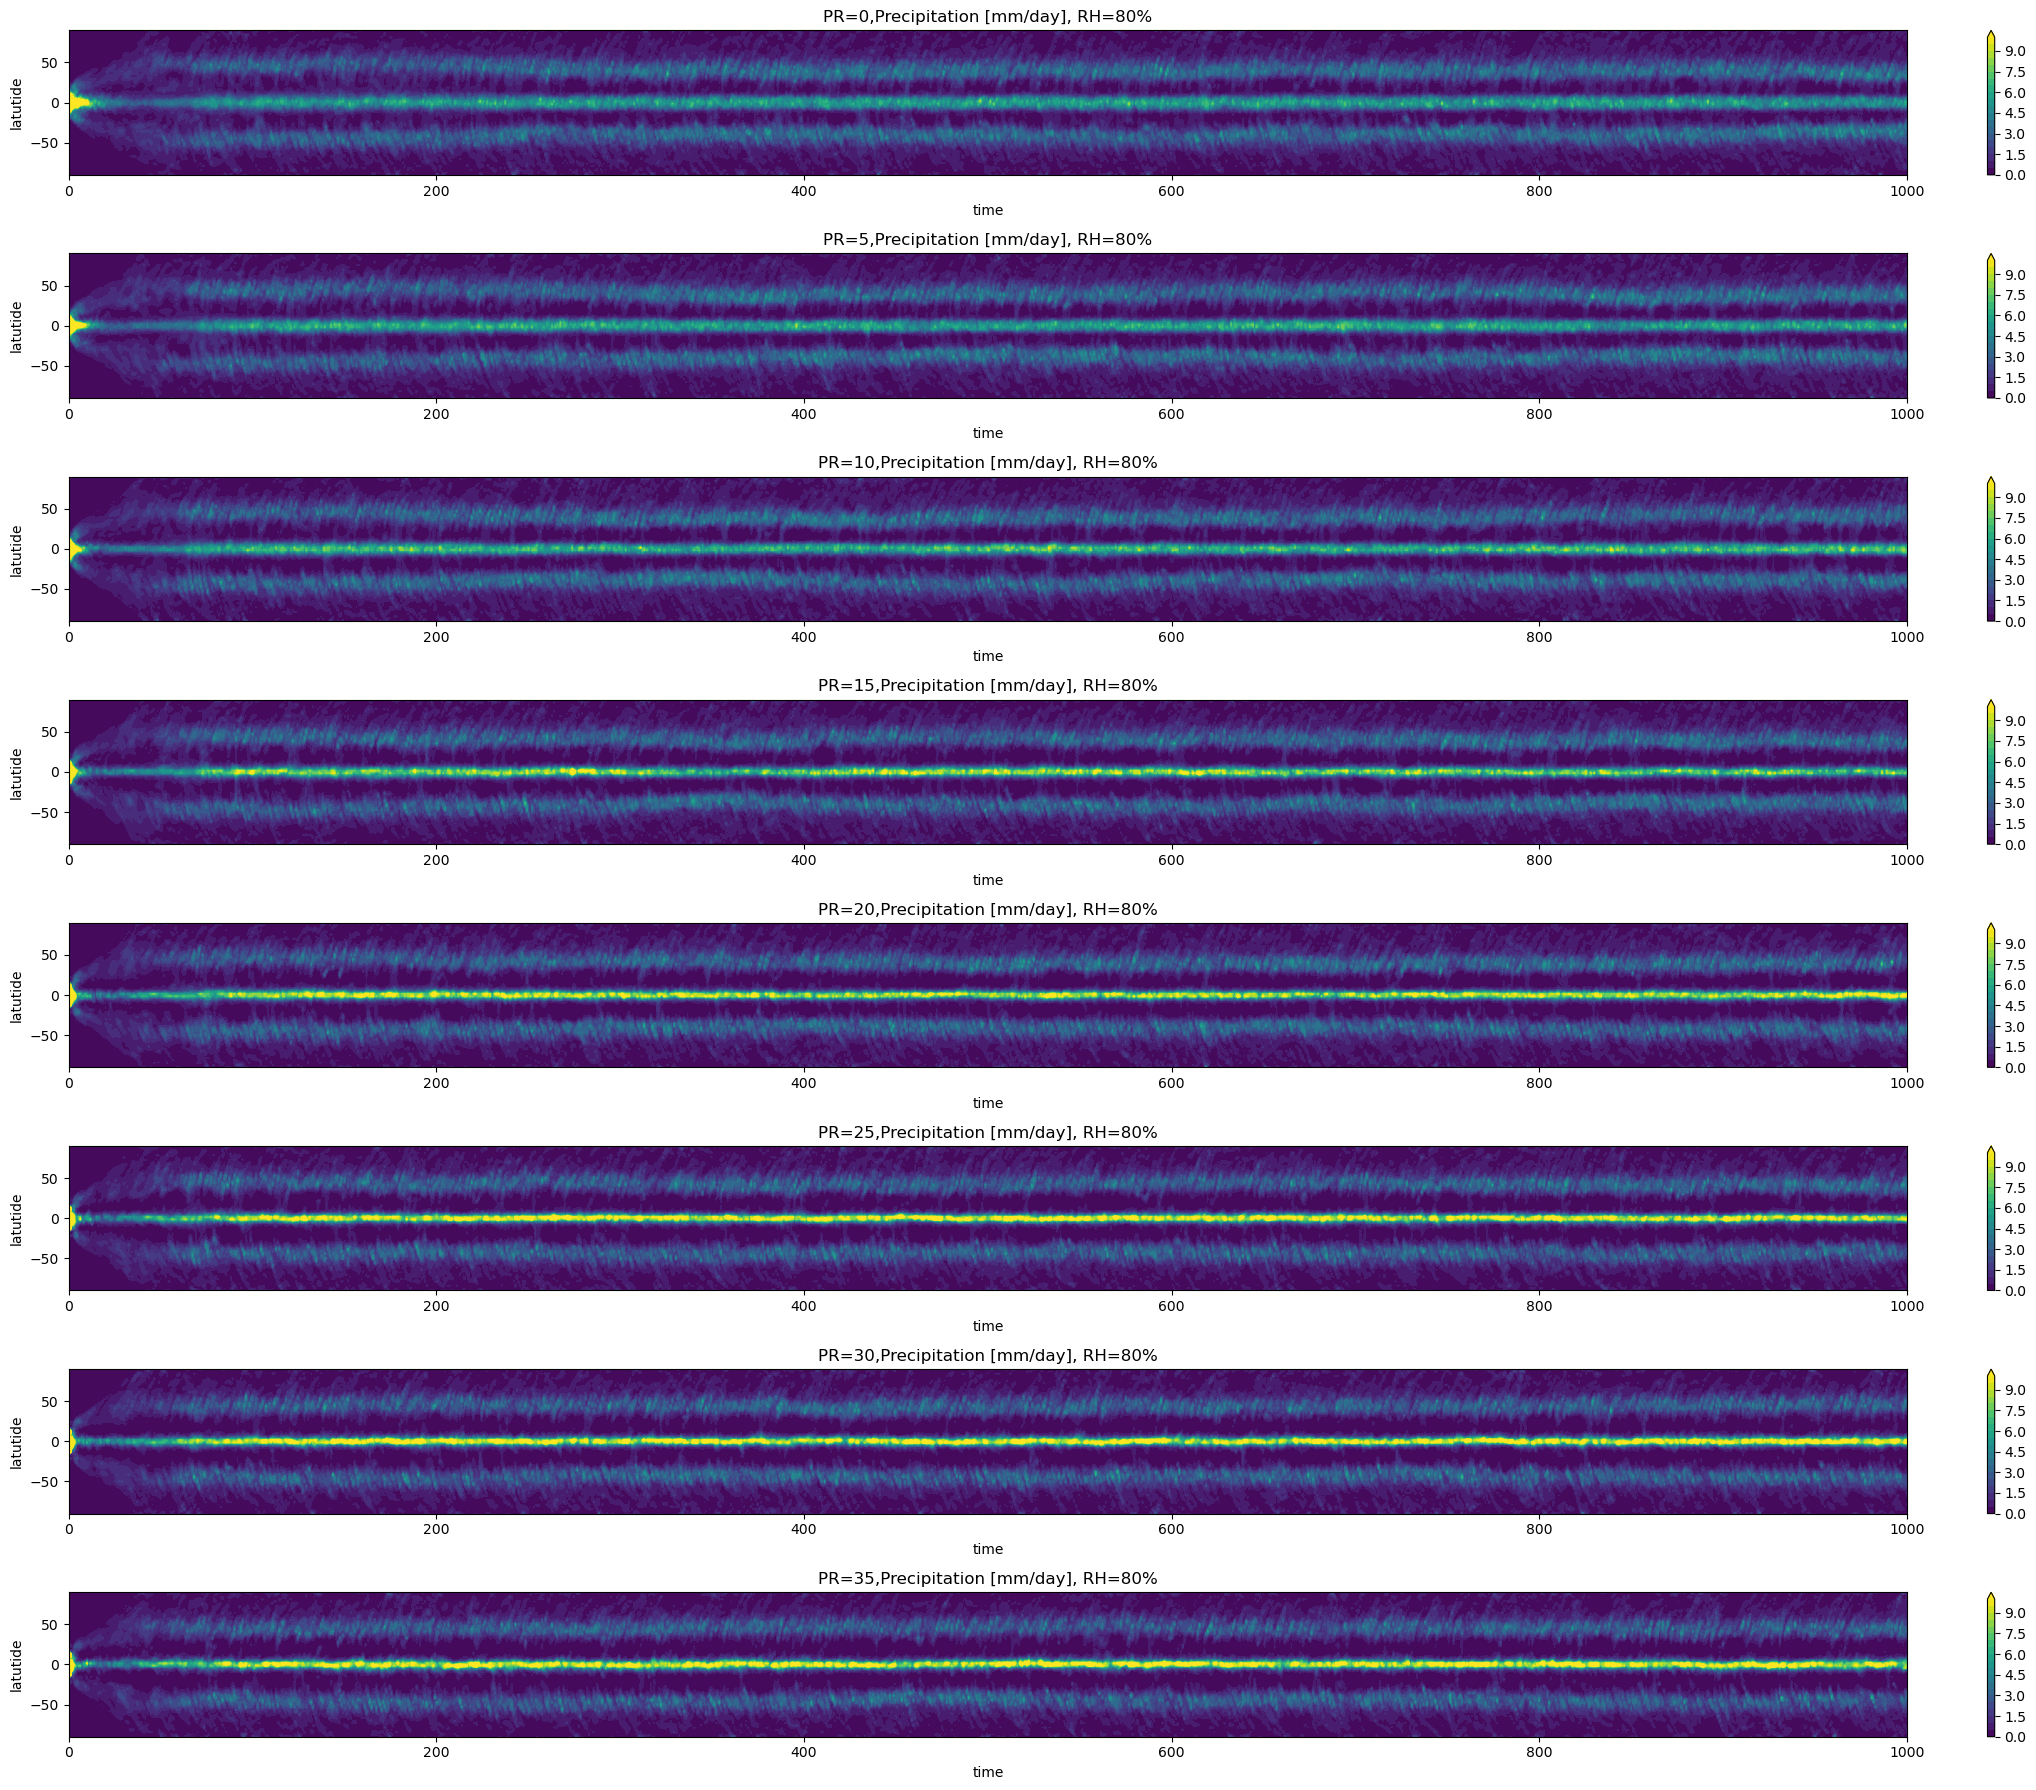

In [880]:
pr_start = 0
pr_leap = 5
pr_to = 40
nProc = 2
# with Pool(nProc) as p:
#     results = [p.apply_async(plot_EMF_80, (t, )) for t in range(0, to, leap)]
#     final_80 = [result.get() for result in results]
# qv   = np.zeros((6,32))
# qv_diff   = np.zeros((6,32))
# u   = np.zeros((6,32))
# v   = np.zeros((6,32))
# t     = np.zeros((6,64))

### fig
yy, tt = np.meshgrid(y,time)
a      = int(0)
fig,ax   = plt.subplots(int((pr_to - pr_start)/pr_leap),figsize=(21,18))
#########

start = 0
end   = 1000
internal_day = 100
total_file = int((end - start) / internal + 1)
# print(total_file)
total_day = int(total_file*internal_day)

qv = np.zeros((((total_day, 20, 64, 128))))
qv_diff = np.zeros((((total_day, 20, 64, 128))))
u = np.zeros((((total_day, 20, 64, 128))))
v = np.zeros((((total_day, 20, 64, 128))))
t = np.zeros((((total_day, 20, 64, 128))))
p = np.zeros((((total_day, 20, 64, 128))))
ps = np.zeros((((total_day, 20, 64, 128))))
p_half = np.zeros((((total_day, 21, 64, 128))))

do_check_qv = True
do_check_KE = False
do_check_t  = False
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_qv:
            if k ==0:
                qv[0:100,:,:,:]      = qv_ini[k,:,:,:,:]
                qv_diff[0:100,:,:,:] = qv_diff_ini[k,:,:,:,:]
                # u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
                # v[0:100,:,:,:]             = v_ini[k,:,:,:,:]
                # t[0:100,:,:,:]             = t_ini[k,:,:,:,:]
                p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
                ps[0:100,:,:,:]             = ps_ini[k,:,:,:,:]
                p_half[0:100,:,:,:]        = p_half_ini[k,:,:,:,:]            
            else:
                qv[k*100:(k+1)*100,:,:,:] = qv_ini[k,:,:,:,:]
                qv_diff[k*100:(k+1)*100,:,:,:] = qv_diff_ini[k,:,:,:,:]
                # u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
                # v[k*100:(k+1)*100,:,:,:] = v_ini[k,:,:,:,:]
                # t[k*100:(k+1)*100,:,:,:] = t_ini[k,:,:,:,:]
                p[k*100:(k+1)*100,:,:,:] = p_ini[k,:,:,:,:]
                ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
                p_half[k*100:(k+1)*100,:,:,:] = p_half_ini[k,:,:,:,:]
                
        if do_check_KE:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
                v[0:100,:,:,:]             = v_ini[k,:,:,:,:]
                p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
                ps[0:100,:,:,:]             = ps_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
                v[k*100:(k+1)*100,:,:,:] = v_ini[k,:,:,:,:]
                p[k*100:(k+1)*100,:,:,:] = p_ini[k,:,:,:,:]
                ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
                
        if do_check_t:
            if k ==0:
                t[0:100,:,:,:]             = t_ini[k,:,:,:,:]
            else:
                t[k*100:(k+1)*100,:,:,:] = t_ini[k,:,:,:,:]
                
                

    if do_check_qv:
        Prec_new   = cal_pre(qv_diff, p_half)
        CS = ax[a].contourf(tt, yy, Prec_new[:,:] * 86400,levels=np.linspace(0,10,21), extend="max")    
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
        ax[a].set_title(f"PR={pr},Precipitation [mm/day], RH=80%")    
        ax[a].set_xlabel("time")
        ax[a].set_ylabel("latutide")
        a += 1
    if do_check_KE:
        get_KE = cal_KE(u, v)   
        CS = ax[a].contourf(tt, yy, get_KE,levels=np.linspace(60,1200,21), extend="both")
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
        ax[a].set_title(f"Kinetic Energy [kJ/kg], PR={pr}")
        ax[-1].set_xlabel("time")
        ax[a].set_ylabel("latutide")
        a += 1
    if do_check_t:
        t_mean = np.nanmean(t[:,:,:,:], axis=(1,3))
        CS = ax[a].contourf(tt, yy, t_mean,levels=21, extend="both")
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
        ax[a].set_title(f"Temperature [K], PR={pr}")
        ax[-1].set_xlabel("time")
        ax[a].set_ylabel("latutide")
        a += 1
        
        
if do_check_qv:
    fig.tight_layout()
    plt.savefig("check_qv_equilibrium.png", dpi=300., bbox_inches='tight')
    plt.show()
if do_check_KE:
    fig.tight_layout()
    # plt.savefig("check_KE_equilibrium.png", dpi=300., bbox_inches='tight')
    plt.show()
if do_check_t:
    fig.tight_layout()
    # plt.savefig("check_T_equilibrium.png", dpi=300., bbox_inches='tight')
    plt.show()

    #     print(result.shape)
    #     print(result)
    # EMF_80[a,:] = EMF_results[32:]
    # EQF_80[a,:] = EQF_results[32:]
    # EHF_80[a,:] = EHF_results[32:]
    # EKF_80[a,:] = EKF_results[32:]
    # prec_80[a,:]  = prec_results[:] #* float(t)

In [816]:
print(qv_diff.shape)

(1100, 20, 64, 128)


# Calculate EOF of u, then plot y-z 

In [817]:
from EOF import EOF

In [818]:
y  = np.linspace(-90,90,64)
yd = np.deg2rad(y)
cy = np.cos(yd)
# cy [0] = np.nan
# cy [-1] = np.nan
cy

array([6.12323400e-17, 4.98458857e-02, 9.95678466e-02, 1.49042266e-01,
       1.98146143e-01, 2.46757398e-01, 2.94755174e-01, 3.42020143e-01,
       3.88434796e-01, 4.33883739e-01, 4.78253979e-01, 5.21435203e-01,
       5.63320058e-01, 6.03804410e-01, 6.42787610e-01, 6.80172738e-01,
       7.15866849e-01, 7.49781203e-01, 7.81831482e-01, 8.11938006e-01,
       8.40025923e-01, 8.66025404e-01, 8.89871809e-01, 9.11505852e-01,
       9.30873749e-01, 9.47927346e-01, 9.62624247e-01, 9.74927912e-01,
       9.84807753e-01, 9.92239207e-01, 9.97203797e-01, 9.99689182e-01,
       9.99689182e-01, 9.97203797e-01, 9.92239207e-01, 9.84807753e-01,
       9.74927912e-01, 9.62624247e-01, 9.47927346e-01, 9.30873749e-01,
       9.11505852e-01, 8.89871809e-01, 8.66025404e-01, 8.40025923e-01,
       8.11938006e-01, 7.81831482e-01, 7.49781203e-01, 7.15866849e-01,
       6.80172738e-01, 6.42787610e-01, 6.03804410e-01, 5.63320058e-01,
       5.21435203e-01, 4.78253979e-01, 4.33883739e-01, 3.88434796e-01,
      

8
(500, 1280)
(500, 1280)
(500, 1280)
(500, 1280)
(500, 1280)
(500, 1280)
(500, 1280)
(500, 1280)


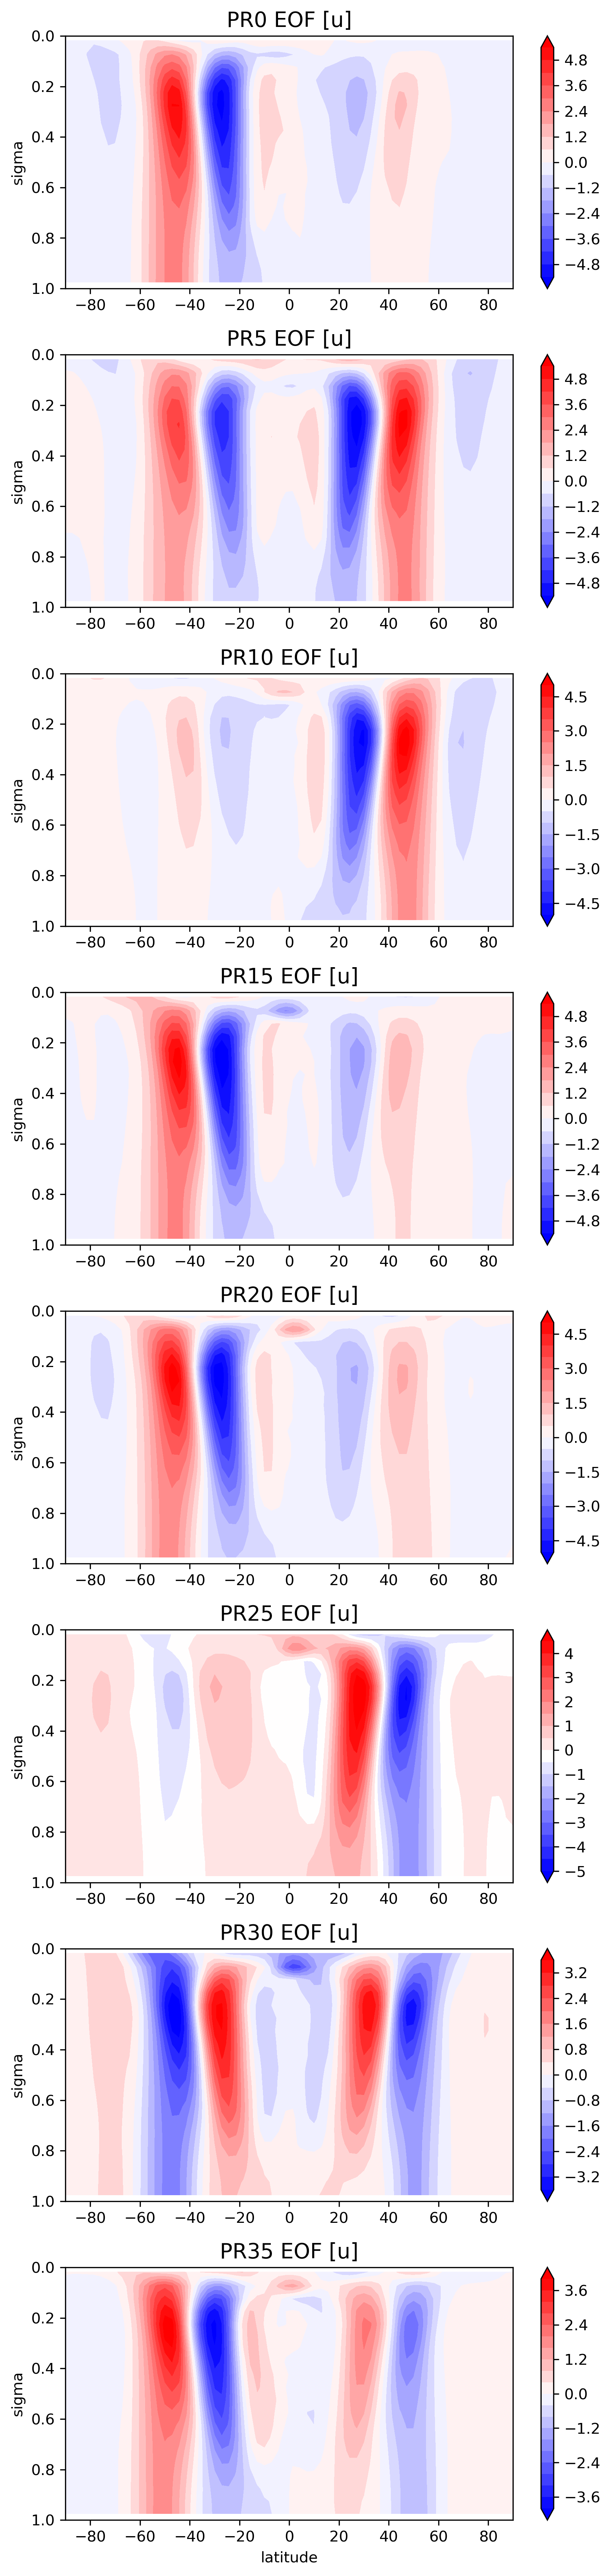

In [893]:
pr_start = 0
pr_leap = 5
pr_to = 40
nProc = 2


### fig
yy, tt = np.meshgrid(y,time)
a      = int(0)
fig,ax   = plt.subplots(int((pr_to - pr_start)/pr_leap),figsize=(6,24), dpi=300.)
print(int((pr_to - pr_start)/pr_leap))
#########

start = 0
end   = 1000
internal_day = 100
total_file = int((end - start) / internal + 1)
# print(total_file)
total_day = int(total_file*internal_day)


u = np.zeros((((total_day, 20, 64, 128))))


do_check_u_EOF = True
check_days_length = int(500)

sigma_mean      = np.nanmean(p[-check_days_length:,:,:,:]/ps[-check_days_length:,:,:,:], axis=(0,3))
sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
y               = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)

a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_u_EOF:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
          
            else:
                u[k*100:(k+1)*100,:,:,:]   = u_ini[k,:,:,:,:]

    # Step 1: weight and time, zonal mean
    u_w = np.zeros((((check_days_length, 20, 64, 128))))
    for i in range(0,64):
        u_w[:,:,i,:] = u[-check_days_length:,:,i,:] * (cy[i])**0.5
    u_w_zy = np.nanmean(u_w[:,:,:,:], axis=(3))
    u_w_zy_reshape = np.reshape(u_w_zy, (check_days_length, 20*64))
    print(u_w_zy_reshape.shape)
    # Step 2: do EOF of u
    single_EOF = EOF((u_w_zy_reshape,), n_components=500, field="1D")
    single_EOF.get()
    # Step 3: PC / PC_std and EOF * PC_std
    PCs   = single_EOF.PC[0,:]
    EOFs  = single_EOF.EOF[0,:]
    
    PCs_std = PCs.std()
    PCs     = PCs / PCs_std
    
    EOFs_std  = EOFs.std()
    EOFs      = EOFs * PCs_std
    # Step 4: reshape (1280,) back to (20,64)
    EOFs_zy = np.reshape(EOFs, (20,64))

    # Step 5: plot
    CS = ax[a].contourf(yy, sigma_mean2, EOFs_zy, levels=21, cmap="bwr", extend="both")
    fig.colorbar(CS, ax=ax[a], extend="both")
    ax[a].set_ylim([1,0])
    ax[a].set_title(f"PR{pr} EOF [u]", fontsize=14)
    ax[a].set_ylabel("sigma")
    ax[-1].set_xlabel("latitude")
    a += 1
fig.tight_layout()
plt.savefig("check_U_EOF.png", dpi=300., bbox_inches='tight')
plt.show()
    # if do_check_u_EOF:
    #     Prec_new   = cal_pre(qv_diff, p_half)
    #     CS = ax[a].contourf(tt, yy, Prec_new[:,:] * 86400,levels=np.linspace(0,10,21), extend="max")    
    #     fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
    #     ax[a].set_title(f"PR={pr},Precipitation [mm/day], RH=80%")    
    #     ax[a].set_xlabel("time")
    #     ax[a].set_ylabel("latutide")
    #     a += 1

(1100, 20, 64, 128)
(500, 1280)


In [822]:
print(EOFs.shape)
print(PCs.shape)

(1280,)
(500,)


(20, 64)


Text(0.5, 0, 'latitude')

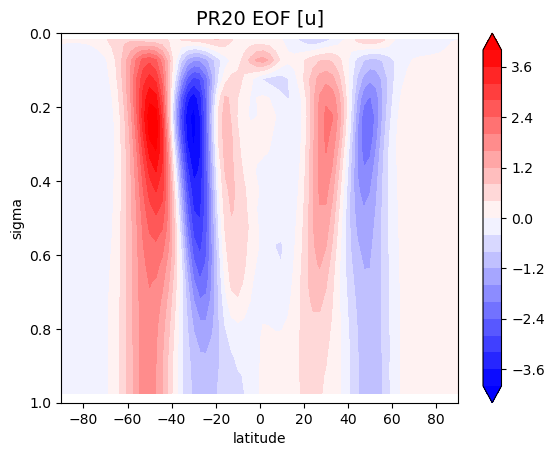

In [825]:

print(yy.shape)

plt.figure()




Text(0.5, 0, 'Day')

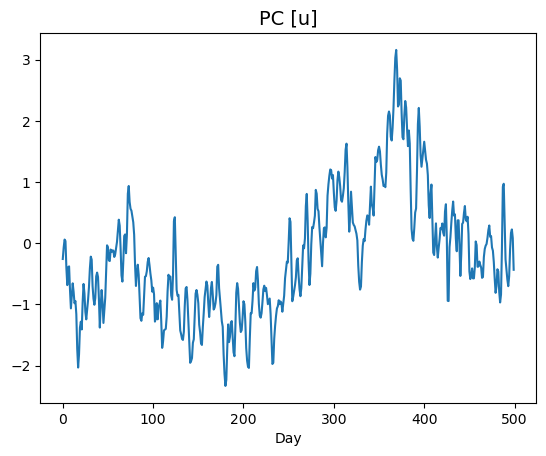

In [826]:
plt.figure()
plt.plot(PCs)
# plt.ylim([1,0])
plt.title("PC [u]", fontsize=14)
# plt.ylabel("sigma")
plt.xlabel("Day")

Text(0.5, 0, 'Day')

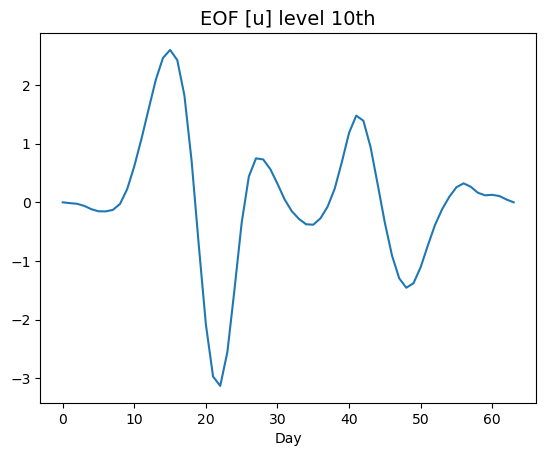

In [827]:
plt.figure()
EOFs_final = np.reshape(EOFs, (20,64))
plt.plot(EOFs_final[10,:])
# plt.ylim([1,0])
plt.title("EOF [u] level 10th", fontsize=14)
# plt.ylabel("sigma")
plt.xlabel("Day")

Text(0.5, 1.0, 'original u')

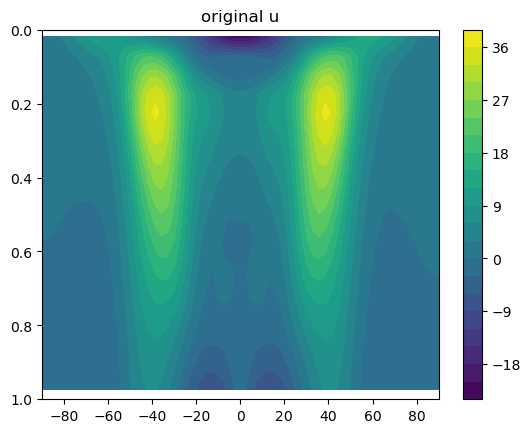

In [828]:
plt.figure()
CS = plt.contourf(yy, sigma_mean2, u_w_zy.mean(axis=0), levels=21)
plt.colorbar(CS)
plt.ylim([1,0])
plt.title("original u")

(500, 1280)


Text(0.5, 1.0, 'test from EOF and PC back to u')

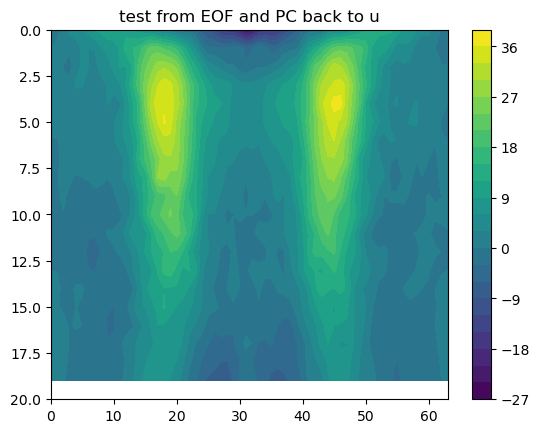

In [829]:
print(np.shape((single_EOF.EOF.T.dot(single_EOF.PC)).T))
test = np.reshape((single_EOF.EOF.T.dot(single_EOF.PC)).T, (500, 20*64))
test_mean = np.nanmean(test, axis=0)
test_final = np.reshape(test_mean, (20,64))
plt.figure()
CS = plt.contourf(test_final, levels=21)
plt.colorbar(CS)
plt.ylim([20,0])
plt.title("test from EOF and PC back to u")

# plot original u different PR

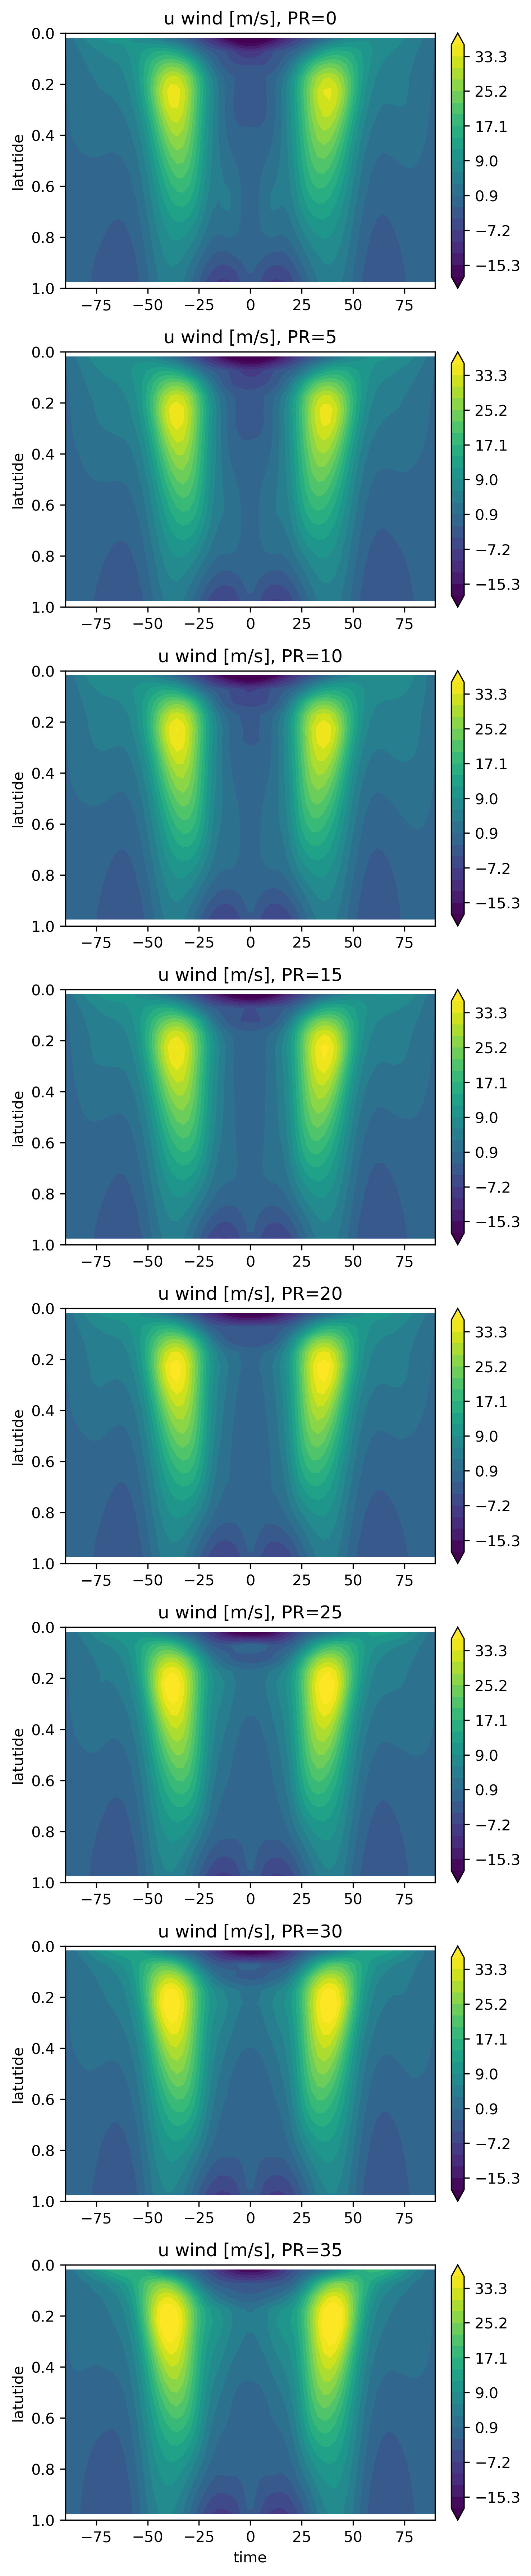

In [871]:
pr_start = 0
pr_leap = 5
pr_to = 40

do_check_u = True
fig,ax   = plt.subplots(8,figsize=(5,24), dpi=300.)
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_u:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
    if do_check_u:
        u_mean = np.nanmean(u, axis=(0,3))
        CS = ax[a].contourf(yy, sigma_mean2, u_mean,levels=np.linspace(-18,36,21), extend="both")
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
        ax[a].set_ylim([1,0])
        ax[a].set_title(f"u wind [m/s], PR={pr}")
        ax[-1].set_xlabel("time")
        ax[a].set_ylabel("latutide")
        a += 1
if do_check_u:
    plt.savefig("check_U_equilibrium.png", dpi=600., bbox_inches='tight')
    fig.tight_layout()
    plt.show()



# Plot different PR latitude profile u

In [ ]:
pr_start = 0
pr_leap = 5
pr_to = 5

do_check_u = True
fig,ax   = plt.subplots(8,figsize=(5,24), dpi=300.)
do_check_u
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_u:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
    if do_check_u:
        u_mean = np.nanmean(u, axis=(0,3))
        CS = ax[a].contourf(yy, sigma_mean2, u_mean,levels=np.linspace(-18,36,21), extend="both")
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
        ax[a].set_ylim([1,0])
        ax[a].set_title(f"u wind [m/s], PR={pr}")
        ax[-1].set_xlabel("time")
        ax[a].set_ylabel("latutide")
        a += 1